#  Importing Libraries


In [207]:
import numpy as np
import pandas as pd

In [239]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
import pickle
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import LeavePOut
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix, classification_report


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saulbarajas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Importing Dataset

In [209]:
df = pd.read_csv('/Users/saulbarajas/Downloads/training.1600000.processed.noemoticon.csv',
                 encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# Analysing the Data

In [210]:
df.shape

(1600000, 6)

In [211]:
df.columns=['sentiments','id','date','query','user','tweet']

In [212]:
df.head()

,sentiments,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [213]:
df=df[['sentiments','tweet']]

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

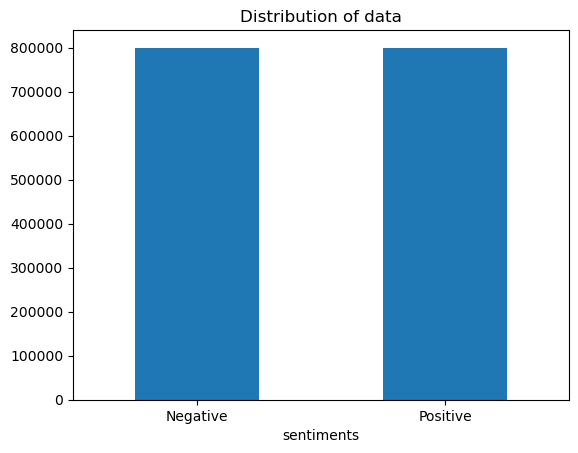

In [214]:
ax = df.groupby('sentiments').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)


# Preprocessing the Data
* Stemming 
* Lematization
* removing Hyperlinks and useraccounts
* removing Stopwords

using NLTK for text processing

In [215]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [216]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [217]:
df.tweet = df.tweet.apply(lambda x: preprocess(x))

In [218]:
tweet , sentiments = list(df['tweet']), list(df['sentiments'])

In [219]:
df.head()

,sentiments,tweet
0,0,awww bummer shoulda got david carr third day
1,0,upset update facebook texting might cry result...
2,0,dived many times ball managed save 50 rest go ...
3,0,whole body feels itchy like fire
4,0,behaving mad see


# Hold-out cross-validation

In [222]:
X_train, X_test, y_train, y_test = train_test_split(tweet,sentiments,test_size=0.2,random_state=0)

# TF-IDF, Bag of Words, Word2Vec Vectorizing

In [220]:
def TFIDFVect(X_train,X_test):
    vectoriser = TfidfVectorizer(ngram_range=(1,2),max_features=50000)
    vectoriser = vectoriser.fit(X_train)
    return vectoriser

In [221]:
def BagWordsVect(X_train,X_test):
    vectoriser = CountVectorizer(ngram_range=(1,2),max_features=50000)
    vectoriser = vectoriser.fit(X_train)
    return vectoriser


In [223]:
vectoriser = TFIDFVect(X_train,X_test)
#vectoriser = BagWordsVect(X_train,X_test)
#vectoriser = Word2Vect(X_train,X_test)
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

# Creating Models

In [234]:
def model_Evaluate(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    

In [246]:
def model_EvaluateKFold(model):
    y_pred = cross_val_predict(model, X_test, y_test, cv=10)
    print(classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

# Logistic Regression

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


              precision    recall  f1-score   support

           0       0.80      0.77      0.79     39989
           4       0.78      0.81      0.79     40011

    accuracy                           0.79     80000
   macro avg       0.79      0.79      0.79     80000
weighted avg       0.79      0.79      0.79     80000



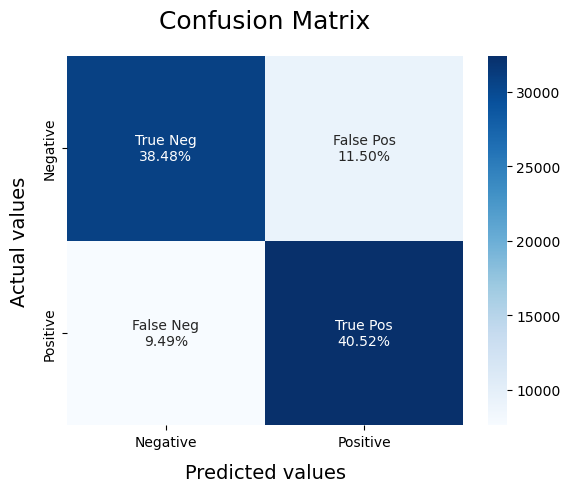

In [149]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

In [ ]:
LRmodelKFold = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
scores = cross_val_score(LRmodelKFold, X_train, y_train, cv=10)
scores

# Linear Support Vector Classification

              precision    recall  f1-score   support

           0       0.80      0.76      0.78     39989
           4       0.77      0.81      0.79     40011

    accuracy                           0.79     80000
   macro avg       0.79      0.79      0.79     80000
weighted avg       0.79      0.79      0.79     80000



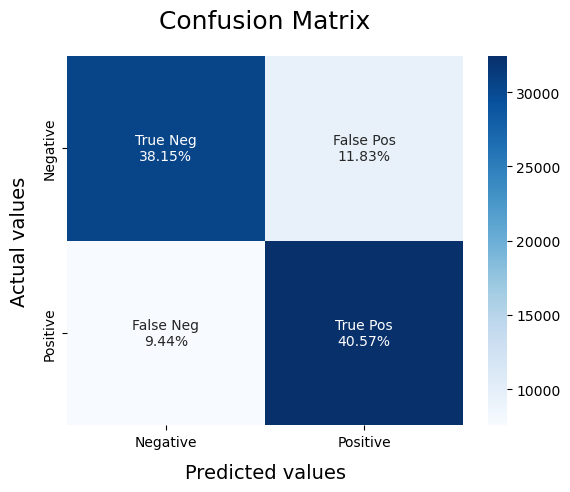

In [150]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)


In [242]:
SVCmodelKFold = LinearSVC()
scores = cross_val_score(SVCmodelKFold, X_train, y_train, cv=10)
scores

array([0.78407812, 0.78316406, 0.78203125, 0.78352344, 0.78199219,
       0.78536719, 0.78425781, 0.78398437, 0.78586719, 0.78442969])

# BernoulliNB

              precision    recall  f1-score   support

           0       0.79      0.76      0.77     39989
           4       0.77      0.80      0.78     40011

    accuracy                           0.78     80000
   macro avg       0.78      0.78      0.78     80000
weighted avg       0.78      0.78      0.78     80000



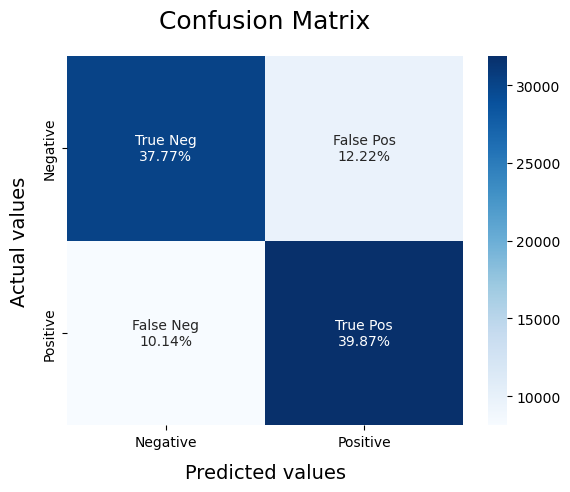

In [151]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

In [241]:
BNBmodelKFold = BernoulliNB(alpha = 2)
scores = cross_val_score(BNBmodelKFold, X_train, y_train, cv=10)
scores

array([0.77428906, 0.77286719, 0.77230469, 0.77355469, 0.77342188,
       0.7751875 , 0.77386719, 0.77305469, 0.77457813, 0.77508594])

In [247]:
Y_pred = cross_val_predict(BNBmodelKFold, X_test, y_test, cv=10)
cf_matrix = confusion_matrix(y_test, Y_pred)
cf_matrix



array([[119585,  40230],
       [ 33946, 126239]])

              precision    recall  f1-score   support

           0       0.78      0.75      0.76    159815
           4       0.76      0.79      0.77    160185

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



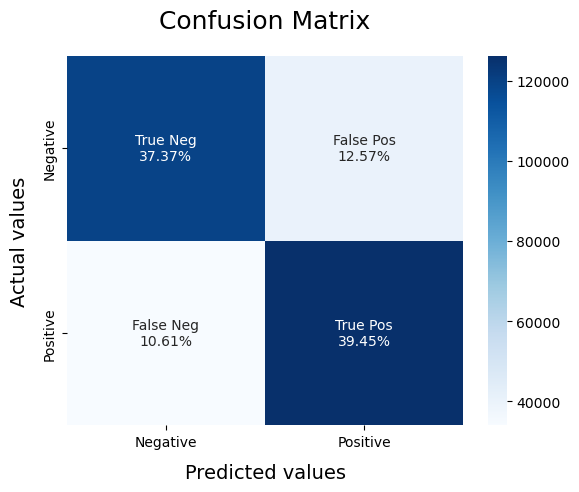

In [248]:
model_EvaluateKFold(BNBmodelKFold)

# MultinomialNB

# Saving the model and vectorizer files

In [21]:
file = open('vectoriser','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-SVC.pickle','wb')
pickle.dump(SVCmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

# Testing the Models

In [22]:
file = open('./vectoriser', 'rb')
vectoriser = pickle.load(file)
file.close()
file = open('./Sentiment-LR.pickle', 'rb')
LRmodel = pickle.load(file)
file.close()
file = open('./Sentiment-BNB.pickle', 'rb')
BNBmodel = pickle.load(file)
file.close()
file = open('./Sentiment-SVC.pickle', 'rb')
SVCmodel = pickle.load(file)
file.close()
    

def predict1(vectoriser, model, tweet):
    textdata = vectoriser.transform(tweet)
    sentiment = model.predict(textdata)
    data = []
    for tweet, pred in zip(tweet, sentiment):
        data.append((tweet,pred))
    df = pd.DataFrame(data, columns = ['tweet','sentiment'])
    df = df.replace([0,4], ["Negative","Positive"])
    return df

def predict2(vectoriser, model, tweet):
    textdata = vectoriser.transform(tweet)
    sentiment = model.predict(textdata)
    data = []
    for tweet, pred in zip(tweet, sentiment):
        data.append((tweet,pred))
    df = pd.DataFrame(data, columns = ['tweet','sentiment'])
    df = df.replace([0,4], ["Negative","Positive"])
    return df

tweet = ["I hate Data ","I love Data ","He passed away at the age 70"]

print("Logistic Regression \n")
df = predict1(vectoriser, LRmodel, tweet)
print(df.head(), "\n")
print("BNB Model \n")
df = predict2(vectoriser, BNBmodel,tweet)
print(df.head(), "\n")
print("SVC Model \n")
df = predict2(vectoriser, SVCmodel,tweet)
print(df.head(),'\n' )

Logistic Regression 

                          tweet sentiment
0                  I hate Data   Negative
1                  I love Data   Positive
2  He passed away at the age 70  Negative 

BNB Model 

                          tweet sentiment
0                  I hate Data   Negative
1                  I love Data   Positive
2  He passed away at the age 70  Negative 

SVC Model 

                          tweet sentiment
0                  I hate Data   Negative
1                  I love Data   Positive
2  He passed away at the age 70  Negative 

